In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
# CNN_DMRI Model Definition, Data Prep, and Training Loop for Colab
"""
Define, inspect, prepare data, and train the CNN_DMRI denoiser interactively in a Colab notebook.
Includes utilities for computing dataset statistics, loading from ZIPs, resizing inputs,
and a train/val loop that tracks MSE loss, SSIM, PSNR, supports early stopping,
and saves checkpointed best model.
"""
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import DataLoader
import zipfile, io
from PIL import Image
from tqdm import tqdm
import math
from pytorch_msssim import ssim
from pathlib import Path
import os

In [ ]:
# ---------------------------------------------
# 1. CNN_DMRI Definition
# ---------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels=128):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class CNN_DMRI(nn.Module):
    def __init__(self):
        super(CNN_DMRI, self).__init__()
        # Initial Convolutions
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        # Downsampling
        self.down1 = nn.Conv2d(64, 128, kernel_size=2, stride=2)
        self.down2 = nn.Conv2d(128, 128, kernel_size=2, stride=2)
        # Residual Blocks
        self.resblocks = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128)
        )
        # Upsampling
        self.up1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        # Output Convolution
        self.out_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)
    def forward(self, x):
        identity = x
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.down1(x)
        x = self.down2(x)
        x = self.resblocks(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.out_conv(x)
        return identity - x  # Global residual learning

In [ ]:
# ---------------------------------------------
# 2. Transforms with Resize
# ---------------------------------------------
mean, std = [0.1781], [0.1976]
target_size = (256, 256)
train_tf = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
val_tf = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
# ---------------------------------------------
# 3. Paired ZIP Dataset Loader
# ---------------------------------------------
class PairedZipDataset(torch.utils.data.Dataset):
    def __init__(self, clean_zip, noisy_zip, transform=None):
        self.clean_zip_path = clean_zip
        self.noisy_zip_path = noisy_zip
        with zipfile.ZipFile(clean_zip, 'r') as zc:
            self.fnames = sorted(
                Path(f).name for f in zc.namelist()
                if f.startswith('clean/') and f.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff'))
            )
        self.transform = transform or (lambda x: x)
        self.zc, self.zn = None, None
    def __len__(self): return len(self.fnames)
    def __getitem__(self, idx):
        if self.zc is None: self.zc = zipfile.ZipFile(self.clean_zip_path)
        if self.zn is None: self.zn = zipfile.ZipFile(self.noisy_zip_path)
        fname = self.fnames[idx]
        clean = Image.open(io.BytesIO(self.zc.read(f'clean/{fname}'))).convert('L')
        noisy = Image.open(io.BytesIO(self.zn.read(f'noisy/{fname}'))).convert('L')
        return self.transform(noisy), self.transform(clean)

In [ ]:
# ---------------------------------------------
# 4. Training Loop with Early Stopping & Checkpoints
# ---------------------------------------------
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3,
                patience=5, checkpoint_dir='checkpoints', device=None):
    print(f">>> train_model called: epochs={epochs}, lr={lr}, patience={patience}")
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    os.makedirs(checkpoint_dir, exist_ok=True)
    best_val_loss, epochs_no_improve = float('inf'), 0

    for ep in range(1, epochs+1):
        print(f"--- Starting Epoch {ep}/{epochs} ---")
        model.train()
        train_loss = train_ssim_sum = 0.0
        for noisy, clean in tqdm(train_loader, desc=f"Epoch {ep}/{epochs} [Train]", leave=False):
            noisy, clean = noisy.to(device), clean.to(device)
            pred = model(noisy)
            loss = criterion(pred, clean)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            train_loss += loss.item() * noisy.size(0)
            batch_ssim = ssim(pred, clean, data_range=1.0, size_average=True).item()
            train_ssim_sum += batch_ssim * noisy.size(0)
        train_loss /= len(train_loader.dataset)
        train_ssim = train_ssim_sum / len(train_loader.dataset)

        model.eval()
        val_loss = val_ssim_sum = psnr_sum = 0.0
        for noisy, clean in tqdm(val_loader, desc=f"Epoch {ep}/{epochs} [Val]", leave=False):
            noisy, clean = noisy.to(device), clean.to(device)
            pred = model(noisy)
            val_loss += criterion(pred, clean).item() * noisy.size(0)
            batch_ssim = ssim(pred, clean, data_range=1.0, size_average=True).item()
            val_ssim_sum += batch_ssim * noisy.size(0)
            mse = (pred-clean).pow(2).mean().item()
            psnr_sum += 10 * math.log10(1.0 / mse) * noisy.size(0)
        val_loss /= len(val_loader.dataset)
        val_ssim = val_ssim_sum / len(val_loader.dataset)
        avg_psnr = psnr_sum / len(val_loader.dataset)

        print(f"Epoch {ep}/{epochs}: Train MSE={train_loss:.4f}, Train SSIM={train_ssim:.4f} | "
              f"Val MSE={val_loss:.4f}, Val SSIM={val_ssim:.4f}, Val PSNR={avg_psnr:.2f}dB")

        if val_loss < best_val_loss:
            best_val_loss = val_loss; epochs_no_improve = 0
            ckpt = os.path.join(checkpoint_dir, f'best_ep{ep}.pth')
            torch.save(model.state_dict(), ckpt)
            print(f"  Saved checkpoint: {ckpt}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {ep}")
                break


In [ ]:
# ---------------------------------------------
# 5. DataLoader & Training Example
# ---------------------------------------------
def collate_fn(batch):
    noisy_list, clean_list = zip(*batch)
    return torch.stack(noisy_list, 0), torch.stack(clean_list, 0)

train_ds = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/train_clean.zip','/content/drive/MyDrive/IA2/dataset/train_noisy.zip', train_tf)
val_ds   = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/val_clean.zip','/content/drive/MyDrive/IA2/dataset/val_noisy.zip', val_tf)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)


In [ ]:
# Instantiate and train CNN_DMRI
model = CNN_DMRI()
train_model(model, train_loader, val_loader)

>>> train_model called: epochs=50, lr=0.001, patience=5
--- Starting Epoch 1/50 ---


Epoch 1/50: Train MSE=0.0864, Train SSIM=0.4500 | Val MSE=0.0652, Val SSIM=0.4894, Val PSNR=12.24dB
  Saved checkpoint: checkpoints/best_ep1.pth
--- Starting Epoch 2/50 ---


Epoch 2/50: Train MSE=0.0558, Train SSIM=0.5308 | Val MSE=0.0488, Val SSIM=0.5624, Val PSNR=13.68dB
  Saved checkpoint: checkpoints/best_ep2.pth
--- Starting Epoch 3/50 ---


Epoch 3/50: Train MSE=0.0448, Train SSIM=0.5676 | Val MSE=0.0407, Val SSIM=0.6028, Val PSNR=14.45dB
  Saved checkpoint: checkpoints/best_ep3.pth
--- Starting Epoch 4/50 ---


Epoch 4/50: Train MSE=0.0394, Train SSIM=0.5849 | Val MSE=0.0403, Val SSIM=0.5872, Val PSNR=14.57dB
  Saved checkpoint: checkpoints/best_ep4.pth
--- Starting Epoch 5/50 ---


Epoch 5/50: Train MSE=0.0367, Train SSIM=0.5961 | Val MSE=0.0359, Val SSIM=0.6141, Val PSNR=15.04dB
  Saved checkpoint: checkpoints/best_ep5.pth
--- Starting Epoch 6/50 ---


Epoch 6/50: Train MSE=0.0328, Train SSIM=0.6156 | Val MSE=0.0435, Val SSIM=0.5623, Val PSNR=14.10dB
--- Starting Epoch 7/50 ---


Epoch 7/50: Train MSE=0.0315, Train SSIM=0.6244 | Val MSE=0.0278, Val SSIM=0.6317, Val PSNR=16.17dB
  Saved checkpoint: checkpoints/best_ep7.pth
--- Starting Epoch 8/50 ---


Epoch 8/50: Train MSE=0.0289, Train SSIM=0.6381 | Val MSE=0.0262, Val SSIM=0.6611, Val PSNR=16.44dB
  Saved checkpoint: checkpoints/best_ep8.pth
--- Starting Epoch 9/50 ---


Epoch 9/50: Train MSE=0.0279, Train SSIM=0.6451 | Val MSE=0.0323, Val SSIM=0.5893, Val PSNR=15.49dB
--- Starting Epoch 10/50 ---


Epoch 10/50: Train MSE=0.0271, Train SSIM=0.6543 | Val MSE=0.0254, Val SSIM=0.6593, Val PSNR=16.53dB
  Saved checkpoint: checkpoints/best_ep10.pth
--- Starting Epoch 11/50 ---


Epoch 11/50: Train MSE=0.0260, Train SSIM=0.6594 | Val MSE=0.0322, Val SSIM=0.6072, Val PSNR=15.39dB
--- Starting Epoch 12/50 ---


Epoch 12/50: Train MSE=0.0251, Train SSIM=0.6694 | Val MSE=0.0315, Val SSIM=0.6263, Val PSNR=15.68dB
--- Starting Epoch 13/50 ---


Epoch 13/50: Train MSE=0.0245, Train SSIM=0.6724 | Val MSE=0.0236, Val SSIM=0.6907, Val PSNR=16.89dB
  Saved checkpoint: checkpoints/best_ep13.pth
--- Starting Epoch 14/50 ---


Epoch 14/50: Train MSE=0.0238, Train SSIM=0.6774 | Val MSE=0.0295, Val SSIM=0.6639, Val PSNR=15.83dB
--- Starting Epoch 15/50 ---


Epoch 15/50: Train MSE=0.0231, Train SSIM=0.6869 | Val MSE=0.0269, Val SSIM=0.6477, Val PSNR=16.18dB
--- Starting Epoch 16/50 ---


Epoch 16/50: Train MSE=0.0226, Train SSIM=0.6903 | Val MSE=0.0230, Val SSIM=0.7010, Val PSNR=16.93dB
  Saved checkpoint: checkpoints/best_ep16.pth
--- Starting Epoch 17/50 ---


Epoch 17/50: Train MSE=0.0222, Train SSIM=0.6967 | Val MSE=0.0225, Val SSIM=0.6994, Val PSNR=17.05dB
  Saved checkpoint: checkpoints/best_ep17.pth
--- Starting Epoch 18/50 ---


Epoch 18/50: Train MSE=0.0223, Train SSIM=0.6984 | Val MSE=0.0373, Val SSIM=0.6429, Val PSNR=14.80dB
--- Starting Epoch 19/50 ---


Epoch 19/50: Train MSE=0.0214, Train SSIM=0.7057 | Val MSE=0.0233, Val SSIM=0.6671, Val PSNR=16.92dB
--- Starting Epoch 20/50 ---


Epoch 20/50: Train MSE=0.0207, Train SSIM=0.7121 | Val MSE=0.0218, Val SSIM=0.6910, Val PSNR=17.16dB
  Saved checkpoint: checkpoints/best_ep20.pth
--- Starting Epoch 21/50 ---


Epoch 21/50: Train MSE=0.0208, Train SSIM=0.7145 | Val MSE=0.0224, Val SSIM=0.7126, Val PSNR=17.07dB
--- Starting Epoch 22/50 ---


Epoch 22/50: Train MSE=0.0206, Train SSIM=0.7151 | Val MSE=0.0231, Val SSIM=0.7062, Val PSNR=17.04dB
--- Starting Epoch 23/50 ---


Epoch 23/50: Train MSE=0.0208, Train SSIM=0.7122 | Val MSE=0.0194, Val SSIM=0.7397, Val PSNR=17.78dB
  Saved checkpoint: checkpoints/best_ep23.pth
--- Starting Epoch 24/50 ---


Epoch 24/50: Train MSE=0.0199, Train SSIM=0.7205 | Val MSE=0.0201, Val SSIM=0.7274, Val PSNR=17.63dB
--- Starting Epoch 25/50 ---


Epoch 25/50: Train MSE=0.0198, Train SSIM=0.7231 | Val MSE=0.0199, Val SSIM=0.7283, Val PSNR=17.68dB
--- Starting Epoch 26/50 ---


Epoch 26/50: Train MSE=0.0191, Train SSIM=0.7276 | Val MSE=0.0219, Val SSIM=0.6824, Val PSNR=17.17dB
--- Starting Epoch 27/50 ---


Epoch 27/50: Train MSE=0.0193, Train SSIM=0.7260 | Val MSE=0.0252, Val SSIM=0.7036, Val PSNR=16.57dB
--- Starting Epoch 28/50 ---


Epoch 28/50: Train MSE=0.0187, Train SSIM=0.7322 | Val MSE=0.0193, Val SSIM=0.7297, Val PSNR=17.76dB
  Saved checkpoint: checkpoints/best_ep28.pth
--- Starting Epoch 29/50 ---


Epoch 29/50: Train MSE=0.0191, Train SSIM=0.7282 | Val MSE=0.0215, Val SSIM=0.6979, Val PSNR=17.25dB
--- Starting Epoch 30/50 ---


Epoch 30/50: Train MSE=0.0182, Train SSIM=0.7378 | Val MSE=0.0191, Val SSIM=0.7294, Val PSNR=17.82dB
  Saved checkpoint: checkpoints/best_ep30.pth
--- Starting Epoch 31/50 ---


Epoch 31/50: Train MSE=0.0186, Train SSIM=0.7348 | Val MSE=0.0210, Val SSIM=0.7353, Val PSNR=17.39dB
--- Starting Epoch 32/50 ---


Epoch 32/50: Train MSE=0.0180, Train SSIM=0.7390 | Val MSE=0.0193, Val SSIM=0.7270, Val PSNR=17.76dB
--- Starting Epoch 33/50 ---


Epoch 33/50: Train MSE=0.0179, Train SSIM=0.7410 | Val MSE=0.0186, Val SSIM=0.7576, Val PSNR=17.99dB
  Saved checkpoint: checkpoints/best_ep33.pth
--- Starting Epoch 34/50 ---


Epoch 34/50: Train MSE=0.0179, Train SSIM=0.7434 | Val MSE=0.0198, Val SSIM=0.7462, Val PSNR=17.68dB
--- Starting Epoch 35/50 ---


Epoch 35/50: Train MSE=0.0198, Train SSIM=0.7298 | Val MSE=0.0179, Val SSIM=0.7580, Val PSNR=18.13dB
  Saved checkpoint: checkpoints/best_ep35.pth
--- Starting Epoch 36/50 ---


Epoch 36/50: Train MSE=0.0173, Train SSIM=0.7493 | Val MSE=0.0196, Val SSIM=0.7349, Val PSNR=17.76dB
--- Starting Epoch 37/50 ---


Epoch 37/50: Train MSE=0.0174, Train SSIM=0.7484 | Val MSE=0.0185, Val SSIM=0.7536, Val PSNR=18.01dB
--- Starting Epoch 38/50 ---


Epoch 38/50: Train MSE=0.0171, Train SSIM=0.7521 | Val MSE=0.0326, Val SSIM=0.6694, Val PSNR=15.21dB
--- Starting Epoch 39/50 ---


Epoch 39/50: Train MSE=0.0174, Train SSIM=0.7488 | Val MSE=0.0180, Val SSIM=0.7634, Val PSNR=18.12dB
--- Starting Epoch 40/50 ---


Epoch 40/50: Train MSE=0.0175, Train SSIM=0.7476 | Val MSE=0.0186, Val SSIM=0.7506, Val PSNR=17.94dB
Early stopping at epoch 40


In [ ]:
# ---------------------------------------------
# 6. Sync checkpoints to Google Drive
# ---------------------------------------------
import shutil

dst_dir = '/content/drive/MyDrive/IA2/cnn_dmri_checkpoints'
shutil.copytree('/content/checkpoints', dst_dir, dirs_exist_ok=True)
print(f"Checkpoints have been copied to {dst_dir}")

Checkpoints have been copied to /content/drive/MyDrive/IA2/cnn_dmri_checkpoints


In [ ]:
# ---------------------------------------------
# 8. Fine-Tune for Additional 20 Epochs with Adjusted LR
# ---------------------------------------------
# Load best checkpoint from Drive for fine-tuning
best_ckpt = '/content/drive/MyDrive/IA2/cnn_dmri_checkpoints/best_ep35.pth'
model.load_state_dict(torch.load(best_ckpt, map_location='cpu'))

# Fine-tune with lower learning rate and larger batch size
# Re-create DataLoaders with batch_size=64 for fine-tuning
fine_train_loader = DataLoader(train_ds,
                                batch_size=64,
                                shuffle=True,
                                num_workers=0)
fine_val_loader   = DataLoader(val_ds,
                                batch_size=64,
                                shuffle=False,
                                num_workers=0)
# Run fine-tuning
train_model(model,
            fine_train_loader,
            fine_val_loader,
            epochs=20,
            lr=5e-4,
            patience=5,
            checkpoint_dir='checkpoints_cnn_dmri_finetune')


<ipython-input-17-3ed3a6b83242>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_ckpt, map_location='cpu'))


>>> train_model called: epochs=20, lr=0.0005, patience=5
--- Starting Epoch 1/20 ---


Epoch 1/20: Train MSE=0.0159, Train SSIM=0.7754 | Val MSE=0.0172, Val SSIM=0.7748, Val PSNR=17.88dB
  Saved checkpoint: checkpoints_cnn_dmri_finetune/best_ep1.pth
--- Starting Epoch 2/20 ---


Epoch 2/20: Train MSE=0.0155, Train SSIM=0.7810 | Val MSE=0.0170, Val SSIM=0.7789, Val PSNR=17.94dB
  Saved checkpoint: checkpoints_cnn_dmri_finetune/best_ep2.pth
--- Starting Epoch 3/20 ---


Epoch 3/20: Train MSE=0.0154, Train SSIM=0.7832 | Val MSE=0.0170, Val SSIM=0.7781, Val PSNR=17.95dB
  Saved checkpoint: checkpoints_cnn_dmri_finetune/best_ep3.pth
--- Starting Epoch 4/20 ---


Epoch 4/20: Train MSE=0.0152, Train SSIM=0.7845 | Val MSE=0.0170, Val SSIM=0.7811, Val PSNR=17.95dB
  Saved checkpoint: checkpoints_cnn_dmri_finetune/best_ep4.pth
--- Starting Epoch 5/20 ---


Epoch 5/20: Train MSE=0.0151, Train SSIM=0.7850 | Val MSE=0.0169, Val SSIM=0.7810, Val PSNR=17.96dB
  Saved checkpoint: checkpoints_cnn_dmri_finetune/best_ep5.pth
--- Starting Epoch 6/20 ---


Epoch 6/20: Train MSE=0.0150, Train SSIM=0.7856 | Val MSE=0.0170, Val SSIM=0.7814, Val PSNR=17.94dB
--- Starting Epoch 7/20 ---


Epoch 7/20: Train MSE=0.0150, Train SSIM=0.7869 | Val MSE=0.0169, Val SSIM=0.7823, Val PSNR=17.96dB
--- Starting Epoch 8/20 ---


Epoch 8/20: Train MSE=0.0149, Train SSIM=0.7867 | Val MSE=0.0168, Val SSIM=0.7826, Val PSNR=18.00dB
  Saved checkpoint: checkpoints_cnn_dmri_finetune/best_ep8.pth
--- Starting Epoch 9/20 ---


Epoch 9/20: Train MSE=0.0148, Train SSIM=0.7873 | Val MSE=0.0169, Val SSIM=0.7819, Val PSNR=17.98dB
--- Starting Epoch 10/20 ---


Epoch 10/20: Train MSE=0.0148, Train SSIM=0.7876 | Val MSE=0.0171, Val SSIM=0.7725, Val PSNR=17.92dB
--- Starting Epoch 11/20 ---


Epoch 11/20: Train MSE=0.0147, Train SSIM=0.7877 | Val MSE=0.0170, Val SSIM=0.7830, Val PSNR=17.94dB
--- Starting Epoch 12/20 ---


Epoch 12/20: Train MSE=0.0146, Train SSIM=0.7893 | Val MSE=0.0168, Val SSIM=0.7834, Val PSNR=17.99dB
--- Starting Epoch 13/20 ---


Epoch 13/20: Train MSE=0.0146, Train SSIM=0.7886 | Val MSE=0.0174, Val SSIM=0.7769, Val PSNR=17.84dB
Early stopping at epoch 13


In [ ]:
# ---------------------------------------------
# 6. Sync checkpoints to Google Drive
# ---------------------------------------------
import shutil

dst_dir = '/content/drive/MyDrive/IA2/cnn_dmri_checkpoints_finetune'
shutil.copytree('/content/checkpoints', dst_dir, dirs_exist_ok=True)
print(f"Checkpoints have been copied to {dst_dir}")

Checkpoints have been copied to /content/drive/MyDrive/IA2/cnn_dmri_checkpoints_finetune


In [ ]:
# ---------------------------------------------
# 9. Test Set Evaluation
# ---------------------------------------------
# Initialize a fresh CNN_DMRI for testing
# (checkpoint path to be set by user)
model = CNN_DMRI()
model.load_state_dict(torch.load('/content/drive/MyDrive/IA2/cnn_dmri_checkpoints_finetune/best_ep8.pth', map_location='cpu'))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prepare test DataLoader
test_ds = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/test_clean.zip', '/content/drive/MyDrive/IA2/dataset/test_noisy.zip', val_tf)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0)

# Collect per-instance metrics
all_mse, all_ssim, all_psnr = [], [], []
with torch.no_grad():
    for noisy, clean in tqdm(test_loader, desc='Testing'):
        noisy, clean = noisy.to(device), clean.to(device)
        pred = model(noisy)
        # denormalize predictions and targets
        pd = pred * std[0] + mean[0]
        cd = clean * std[0] + mean[0]
        # per-image MSE
        per_mse = ((pd - cd)**2).mean(dim=[1,2,3]).cpu().tolist()
        all_mse.extend(per_mse)
        # per-image SSIM
        batch_ssim = ssim(pd, cd, data_range=1.0, size_average=False).cpu().tolist()
        all_ssim.extend(batch_ssim)
        # per-image PSNR
        all_psnr.extend([10 * math.log10(1.0 / m) for m in per_mse])

# Compute and print averages
test_mse = sum(all_mse) / len(all_mse)
test_ssim = sum(all_ssim) / len(all_ssim)
test_psnr = sum(all_psnr) / len(all_psnr)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test SSIM: {test_ssim:.4f}")
print(f"Test PSNR: {test_psnr:.2f} dB")

<ipython-input-21-c2ccd241423f>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/IA2/cnn_dmri_checkpoints_finetune/b

Test MSE: 0.0010
Test SSIM: 0.8357
Test PSNR: 32.17 dB


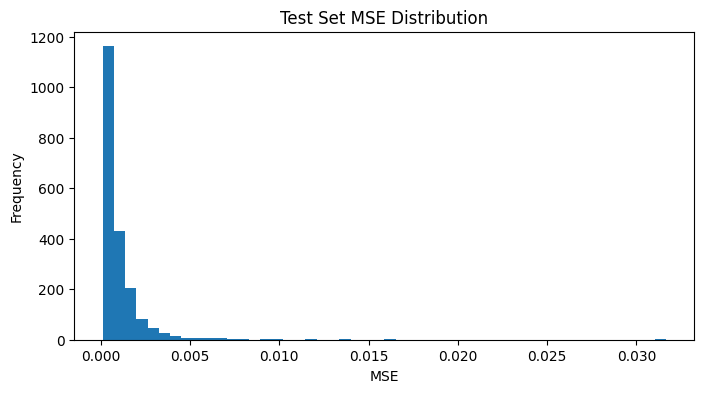

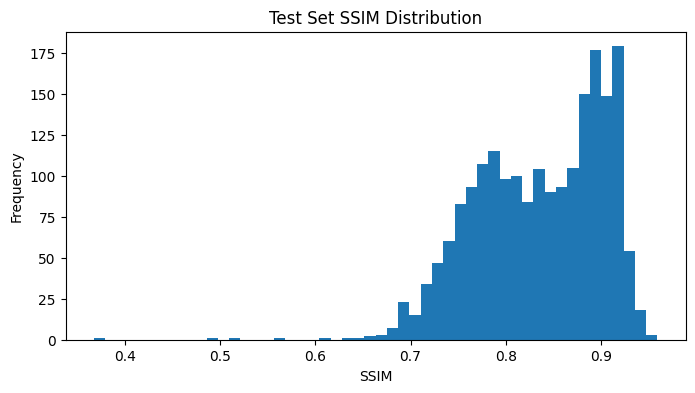

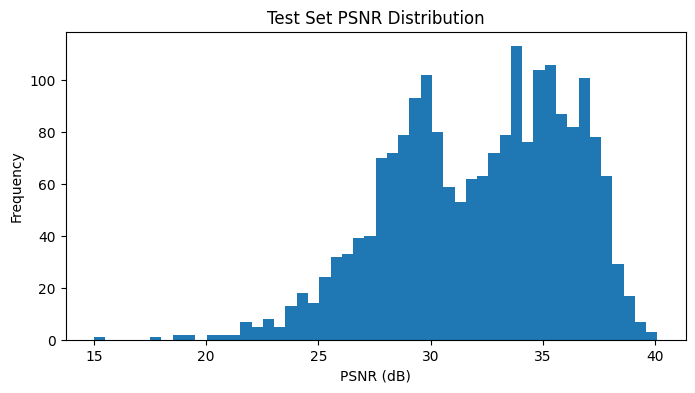

In [ ]:
# ---------------------------------------------
# 10. Plot Histograms of Test Metrics
# ---------------------------------------------
# Plot MSE histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(all_mse, bins=50)
plt.title('Test Set MSE Distribution')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()

# Plot SSIM histogram
plt.figure(figsize=(8,4))
plt.hist(all_ssim, bins=50)
plt.title('Test Set SSIM Distribution')
plt.xlabel('SSIM')
plt.ylabel('Frequency')
plt.show()

# Plot PSNR histogram
plt.figure(figsize=(8,4))
plt.hist(all_psnr, bins=50)
plt.title('Test Set PSNR Distribution')
plt.xlabel('PSNR (dB)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# ---------------------------------------------
# 11. Visualize Sample Denoising Results
# ---------------------------------------------
import random
# Select 10 random indices
indices = random.sample(range(len(test_ds)), 10)

# Prepare a figure with 3 columns: Noisy | Denoised | Clean
fig, axes = plt.subplots(10, 3, figsize=(9, 30))
for i, idx in enumerate(indices):
    noisy_img, clean_img = test_ds[idx]
    # Denoise via model
    with torch.no_grad():
        denoised = model(noisy_img.unsqueeze(0).to(device)).squeeze(0).cpu()
    # Denormalize for display
    def denorm(t): return (t * std[0] + mean[0]).squeeze().cpu().numpy()
    noisy_disp = denorm(noisy_img)
    denoised_disp = denorm(denoised)
    clean_disp = denorm(clean_img)
    # Plot
    axes[i, 0].imshow(noisy_disp, cmap='gray'); axes[i, 0].axis('off'); axes[i, 0].set_title('Noisy')
    axes[i, 1].imshow(denoised_disp, cmap='gray'); axes[i, 1].axis('off'); axes[i, 1].set_title('Denoised')
    axes[i, 2].imshow(clean_disp, cmap='gray'); axes[i, 2].axis('off'); axes[i, 2].set_title('Clean')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.